In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import spherical_jn

from utils import calc_n_max_l
from generate_f_lmn import p

from compute_likelihood_lsst import calc_W

from distance_redshift_relation import *


In [2]:
omega_matter_true = 0.315
omega_matter_0 = 0.315
l_max = 15
k_max = 50
r_max_true = 1.5


radii_true = np.linspace(0, r_max_true, 1001)
true_z_of_r = getInterpolatedZofR(omega_matter_true)
z_true = true_z_of_r(radii_true)

r_of_z_fiducial = getInterpolatedRofZ(omega_matter_0)
radii_fiducial = r_of_z_fiducial(z_true)
r_max_0 = radii_fiducial[-1]

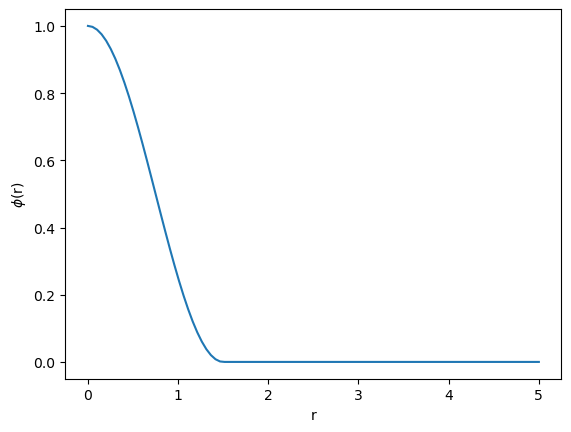

In [3]:
# Define a selection function with the form of a cosine
# That goes to 0 at the boundary

r_max_true = 1.5
phi_r_max = r_max_true

def phi(r):
    return ((np.cos(r * np.pi/phi_r_max) + 1)/2) * (r < phi_r_max)

plt.plot(np.linspace(0, 5, 100), phi(np.linspace(0, 5, 100)))
plt.xlabel("r")
plt.ylabel("$\phi$(r)")
plt.show()

In [4]:
n, n_prime, l = 100, 140, 0

# Omega_matter used in inference
omega_matter = 0.315
r0OfR = getInterpolatedR0ofR(omega_matter_0, omega_matter)
rOfR0 = getInterpolatedR0ofR(omega_matter, omega_matter_0)

# Accuracy settings
Nsplit = 10
epsabs = 1.49e-8

W = calc_W(n, n_prime, l, r_max_0, r0OfR, phi, Nsplit, epsabs)
print(W)

-9.667033891748017e-14


In [7]:
Nsplit_vals = [10, 1000, 10000]

for Nsplit in Nsplit_vals:
    W = calc_W(n, n_prime, l, r_max_0, r0OfR, phi, Nsplit, epsabs)
    print("Nsplit = %d, W = %.8e" % (Nsplit, W))

Nsplit = 10, W = -9.66703389e-14
Nsplit = 1000, W = 1.34013658e-19
Nsplit = 10000, W = -9.43979538e-20


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import spherical_jn

from utils import calc_n_max_l, computeIntegralSplit
from precompute_c_ln import get_c_ln_values_without_r_max
from precompute_sph_bessel_zeros import loadSphericalBesselZeros
from generate_f_lmn import p


c_ln_values_without_r_max = get_c_ln_values_without_r_max("c_ln.csv")
sphericalBesselZeros = loadSphericalBesselZeros("zeros.csv")



In [9]:

def calc_W(n, n_prime, l, r_max, r0OfR, phiOfR0, Nsplit=10, epsabs=1.49e-8, plot=False):
    k_ln = sphericalBesselZeros[l][n] / r_max
    k_ln_prime = sphericalBesselZeros[l][n_prime] / r_max


    def W_integrand(r):
        r0 = r0OfR(r)

        return phiOfR0(r0) * spherical_jn(l, k_ln_prime*r) * spherical_jn(l, k_ln*r0) * r*r

    if plot:
        x = np.linspace(0, r_max, 3001)
        plt.plot(x, W_integrand(x))
        plt.show()


    integral = computeIntegralSplit(W_integrand, Nsplit, r_max, epsabs)

    return np.power(r_max, -3/2) * c_ln_values_without_r_max[l][n_prime] * integral

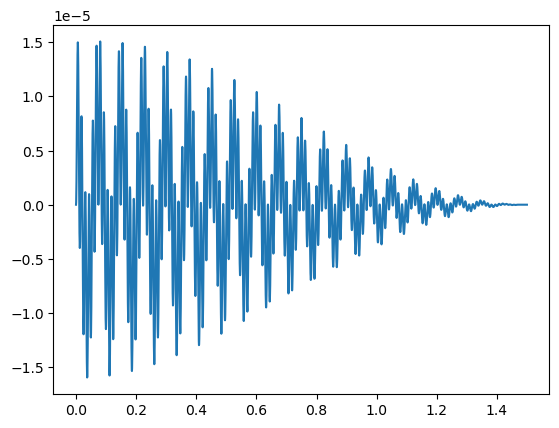

4.527720584792479e-19

In [10]:
calc_W(n, n_prime, l, r_max_0, r0OfR, phi, 100, epsabs, plot=True)

Here, we switch to splitting the integral for W up into chunks by zeros of the integrand.

$$W_{nn'}^{l} = c_{l n'} \int_{0}^{r_\text{max}} \phi(r_{0}) j_{l}(k_{l n'}r) j_{l}(k_{ l n}r_{0}) \, r^{2}dr$$

In [10]:
from utils import integrateWSplitByZeros

print("Splitting integral up into chunks by zeros.")
print("Quad")
print(integrateWSplitByZeros(n, n_prime, l, r_max_0, r0OfR, rOfR0, phi, simpson=False, simpsonNpts=0))
print("Simpson")
print(integrateWSplitByZeros(n, n_prime, l, r_max_0, r0OfR, rOfR0, phi, simpson=True, simpsonNpts=51))
print(integrateWSplitByZeros(n, n_prime, l, r_max_0, r0OfR, rOfR0, phi, simpson=True, simpsonNpts=101))
print(integrateWSplitByZeros(n, n_prime, l, r_max_0, r0OfR, rOfR0, phi, simpson=True, simpsonNpts=1001))
print(integrateWSplitByZeros(n, n_prime, l, r_max_0, r0OfR, rOfR0, phi, simpson=True, simpsonNpts=10001))

Splitting integral up by zeros.
Quad
-2.9529668153622915e-05
Simpson
-2.9529671341876382e-05
-2.9529668352760798e-05
-2.9529668153974752e-05
-2.952966815460191e-05


In [11]:
# Quad
%timeit integrateWSplitByZeros(n, n_prime, l, r_max_0, r0OfR, rOfR0, phi, simpson=False, simpsonNpts=0)

258 ms ± 51.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%timeit integrateWSplitByZeros(n, n_prime, l, r_max_0, r0OfR, rOfR0, phi, simpson=True, simpsonNpts=51)

33.6 ms ± 7.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
%timeit integrateWSplitByZeros(n, n_prime, l, r_max_0, r0OfR, rOfR0, phi, simpson=True, simpsonNpts=101)

34.8 ms ± 6.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%timeit integrateWSplitByZeros(n, n_prime, l, r_max_0, r0OfR, rOfR0, phi, simpson=True, simpsonNpts=1001)

52.9 ms ± 6.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
%timeit integrateWSplitByZeros(n, n_prime, l, r_max_0, r0OfR, rOfR0, phi, simpson=True, simpsonNpts=10001)

294 ms ± 71.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
